# Explore how many PCA Components to Keep and Hyperparameter Tuning 
# (Queries with subset of the diseases)

__Purpose__

Address issue #106 (https://github.com/cognoma/machine-learning/issues/106). Evaluate queries that don't inlcude all the samples but rather subset the samples by disease(s).

__Assumptions/Notes:__

This notebook differs from the current classifier in a number of ways including:
1. In this notebook, PCA is performed on the entire training set prior to cross-validation rather than performed on each individual cross-validation split. This is done for simplicity and to save time and memory.
2. In this notebook, the covariates data is not used (for now at least).


__To Do:__

1. Some additional evaluation and... select a final setup.
2. _We could also try to add the covariates data into this evaluation and see how that changes things but I'm not planning on doing that at this point._

## Outline:
1. Imports, constants and load the data
2. Build the querry set
    * List of genes
    * Summary stats for each gene-disease combo
    * Generate a set of queries
3. Evaluate queries with a subset of diseases and varying number of positives
 - a. Define some helper functions
 - b. See how the parameters are related using the current setup
 - c. Evaluate how changing some of the parameters effects performance
 - d. See if we can use a function to automatically select the number of components

## 1. Imports, constants and load the data

In [1]:
import os
import time
import random
import math

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from dask_searchcv import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest

In [2]:
RANDOMSEED = 0

In [3]:
%%time
# Load the data
try: 
    path = os.path.join('download', 'expression-matrix.pkl')
    X = pd.read_pickle(path)
except:
    path = os.path.join('download', 'expression-matrix.tsv.bz2')
    X = pd.read_table(path, index_col=0)

try:
    path = os.path.join('download', 'mutation-matrix.pkl')
    y = pd.read_pickle(path)
except:
    path = os.path.join('download', 'mutation-matrix.tsv.bz2')
    y = pd.read_table(path, index_col=0)
    
path = os.path.join('download', 'covariates.tsv')
covariates = pd.read_table(path,index_col=0)

Wall time: 7.6 s


## 2. Build the query set

In [4]:
# List of genes to iterate over (from brankaj's notebook: 
# https://github.com/cognoma/machine-learning/blob/master/explore/Classifier_results-different_genes.ipynb)
genes_LungCancer = {
    '207': 'AKT1', 
    '238': 'ALK',  
    '673': 'BRAF', 
    '4921':'DDR2',
    '1956':'EGFR',
    '2064':'ERBB2',
    '3845':'KRAS',
    '5604':'MAP2K1',
    '4893':'NRAS',
    '5290':'PIK3CA',
    '5728':'PTEN',
    '5979':'RET',
    # '6016':'RIT1', (removed because too few positives)
    '6098':'ROS1',
}

genes_TumorSuppressors = {
    '324': 'APC',  
    '672': 'BRCA1',  
    '675': 'BRCA2',
    '1029':'CDKN2A',
    '1630':'DCC',
    '4089':'SMAD4',
    '4087':'SMAD2',
    '4221':'MEN1',
    '4763':'NF1',
    '4771':'NF2',
    '7157':'TP53', 
    '5728':'PTEN', 
    '5925':'RB1',
    '7428':'VHL',
    '7486':'WRN',
    '7490':'WT1',
}

genes_Oncogenes = {
    #'5155':'PDGFB', #growth factor (removed because too few positives)
    '5159':'PDGFRB', #growth factor 
    '3791':'KDR', #receptor tyrosine kinases
    '25':'ABL1', #Cytoplasmic tyrosine kinases
    '6714':'SRC', #Cytoplasmic tyrosine kinases
    '5894':'RAF1',#cytoplasmic serine kinases
    '3265':'HRAS',#regulatory GTPases
    '4609':'MYC',#Transcription factors
    #'2353':'FOS',#Transcription factors (removed because too few positives)
    
}

list_of_genes = (list(genes_LungCancer.keys()) + list(genes_TumorSuppressors.keys()) + 
    list(genes_Oncogenes.keys()))

Create a dictionary of {gene: 
{disease: 
{total: #, positive: #, negative: #}, ...

In [5]:
%%time
disease_list_acronyms = [col for col in covariates.columns if col.startswith('acronym_')]
disease_list = [disease.strip('acronym_') for disease in disease_list_acronyms]
gene_dict = {}
for gene in list_of_genes:
    # Subset by gene.
    y_gene = y[gene]    
    gene_dict[gene] = dict.fromkeys(disease_list)
    for disease in disease_list:
        # Subset by disease.
        disease_cols = [col for col in disease_list_acronyms if col.endswith(disease)]
        has_disease = covariates[disease_cols].max(axis=1) > 0
        disease_cols = covariates[has_disease]
        y_gene_disease = y_gene[y_gene.index.isin(disease_cols.index)]
        # Get query stats.
        stats = {}
        stats['total'] = y_gene_disease.shape[0]
        stats['positive'] = y_gene_disease.sum()
        stats['negative'] = stats['total'] - stats['positive']
        gene_dict[gene][disease] = stats

Wall time: 3.49 s


In [6]:
'''Randomly iterate through gene/disease(s) combinations to create a list
of queries that we can use for analysis. Something like:
[ [gene, [disease1, disease2, etc], {total: #, negative: #, positive: #}], ]

Try to provide general coverage of the
different possibilities of class balance and total sample size while using
the following constraints:
1. All queries should have at least 20 positives.
2. Only use one gene per query (for simplicity).
'''

def generate_queries(randomseed = 0, positive_bound = 20):
    random.seed(randomseed)
    queries = []
    keys_gene = list(gene_dict.keys())
    random.shuffle(keys_gene)
    for gene in keys_gene:
        keys_disease = list(gene_dict[gene].keys())
        random.shuffle(keys_disease)
        total_total, total_positives, total_negatives = 0, 0, 0
        diseases = []
        for disease in keys_disease:
            if total_positives < positive_bound:
                total_total += gene_dict[gene][disease]['total']
                total_positives += gene_dict[gene][disease]['positive']
                diseases.append(disease)

        total_negatives = total_total - total_positives
        num_diseases = len(diseases)
        query = [gene, diseases, {'total': total_total, 'positive': total_positives, 'negative': total_negatives}]
        if query[2]['positive'] >= positive_bound:
            queries.append(query)
    return(queries)

query_list1 = generate_queries(randomseed = 0, positive_bound = 20)
query_list2 = generate_queries(randomseed = 1, positive_bound = 60)
query_list3 = generate_queries(randomseed = 2, positive_bound = 100)
query_list4 = generate_queries(randomseed = 3, positive_bound = 200)
query_list5 = generate_queries(randomseed = 4, positive_bound = 400)
query_list6 = generate_queries(randomseed = 5, positive_bound = 500)
query_list = query_list1 + query_list2 + query_list3 + query_list4 + query_list5 + query_list6
print('There are ' + str(len(query_list)) + ' queries in the list.')

There are 106 queries in the list.


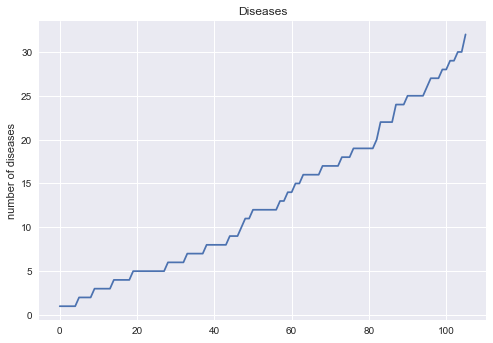

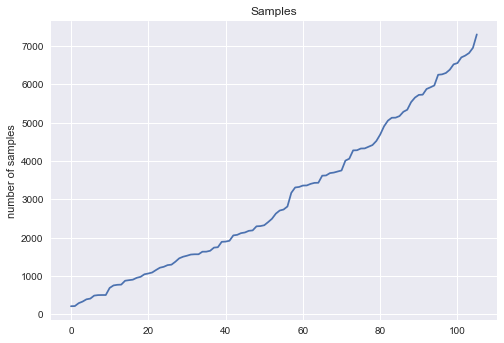

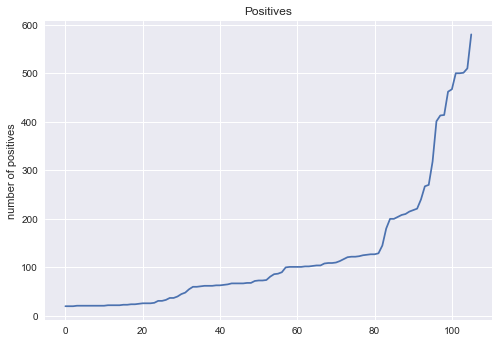

In [7]:
# Visuallize our query set to make sure it's not too skewed
number_of_diseases =[]
for query in query_list:
    number_of_diseases.append(len(query[1]))
number_of_diseases.sort()
plt.plot(number_of_diseases)
plt.ylabel('number of diseases')
plt.title('Diseases')
plt.show()

number_of_samples =[]
for query in query_list:
    number_of_samples.append(query[2]['total'])
number_of_samples.sort()
plt.plot(number_of_samples)
plt.title('Samples')
plt.ylabel('number of samples')
plt.show()

number_of_positives =[]
for query in query_list:
    number_of_positives.append(query[2]['positive'])
number_of_positives.sort()
plt.plot(number_of_positives)
plt.title('Positives')
plt.ylabel('number of positives')
plt.show()

## 3. Evaluate queries with different subsets of diseases and varying number of positives

### 3.a. Define some helper functions

In [8]:
def variance_scorer(x, y):
    """    
    Get the variance for each column of X.
    
    Because principal components have decreasing variance
    (i.e. PC4 has less variance than PC3 which has less variance
    than PC2 etc.), we can use this function in SelectKBest to select
    only the top X number of principal components.
    
    """
    scores = [np.var(column) for column in x.T]
    return scores, np.array([np.NaN]*len(scores))

In [9]:
def evaluate_classifier(X,
                        y,
                        list_of_queries,
                        set_k_range, k_function,
                        alpha_range, 
                        l1_ratio):
    
    ''' Run a classifier setup on a set of queries.
    
        Loop through each query; train and test the classifier using the
        hyperparameters input as parameters; populate the metrics dictionary
        with some metrics of which parameters were selected and how well
        the classifier did for that query.
    '''
    
    # A dictionary to hold the performance metrics.
    metrics_dict = {}
    
    # Loop through each query; train and test the classifer; populate the metrics dictionary.
    for query in list_of_queries:
        num_samples = query[2]['total']
        num_positives = query[2]['positive']
        
        # Subset by gene.
        y_query = y[query[0]]
        # Subset by diseases.
        disease_cols = [col for col in covariates.columns if col.endswith(tuple(query[1]))]
        has_disease = covariates[disease_cols].max(axis=1) > 0
        covariates_query = covariates[has_disease]
        X_query = X[X.index.isin(covariates_query.index)]
        y_query = y_query[y_query.index.isin(covariates_query.index)]
                
        # Test Train split
        test_size = 0.2
        X_train, X_test, y_train, y_test = train_test_split(X_query, y_query, stratify=y_query, test_size=test_size, random_state=RANDOMSEED)
        # PCA.
        scaler = StandardScaler()
        if query[2]['total']*(1-test_size)*(1-(1/3)) > 350:
            n_comp = 350
        else:
            n_comp = int(query[2]['total']*(1-test_size) - 1)
        pca = PCA(n_components = n_comp, random_state = RANDOMSEED)
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        pca.fit(X_train_scaled)
        X_train = pca.transform(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        X_test = pca.transform(X_test_scaled)
        
        if set_k_range:
            k_range = set_k_range
        else:
            k_range = k_function(num_samples=num_samples,
                                 num_positives=num_positives,
                                 )     
        # Parameter Sweep for Hyperparameters
        param_grid = {
            'select__k': k_range,
            'classify__loss': ['log'],
            'classify__penalty': ['elasticnet'],
            'classify__alpha': alpha_range,
            'classify__l1_ratio': l1_ratio,
        }
        pipeline = Pipeline(steps=[
            ('select', SelectKBest(variance_scorer)),
            ('classify', SGDClassifier(random_state=RANDOMSEED, class_weight='balanced'))
        ])
        cv_pipeline = GridSearchCV(estimator=pipeline, 
                                   param_grid=param_grid,
                                   n_jobs=1, 
                                   scoring='roc_auc')
        cv_pipeline.fit(X=X_train, y=y_train)
        y_pred_train = cv_pipeline.decision_function(X_train)
        y_pred_test = cv_pipeline.decision_function(X_test)
        # Get ROC info.
        def get_threshold_metrics(y_true, y_pred):
            roc_columns = ['fpr', 'tpr', 'threshold']
            roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
            roc_df = pd.DataFrame.from_items(roc_items)
            auroc = roc_auc_score(y_true, y_pred)
            return {'auroc': auroc, 'roc_df': roc_df}
        metrics_train = get_threshold_metrics(y_train, y_pred_train)
        metrics_test = get_threshold_metrics(y_test, y_pred_test)

        # Populate the metrics dictionary.
        # Get metrics for the classifier.
        overfit = metrics_train['auroc'] - metrics_test['auroc']
        # Understand how the parameter grid worked... any params at the edge?
        if cv_pipeline.best_params_['select__k'] == min(param_grid['select__k']):
            n_comp_status = 'min'
        elif cv_pipeline.best_params_['select__k'] == max(param_grid['select__k']):
            n_comp_status = 'max'
        else:
            n_comp_status = 'OK'
        if cv_pipeline.best_params_['classify__alpha'] == min(param_grid['classify__alpha']):
            alpha_status = 'min'
        elif cv_pipeline.best_params_['classify__alpha'] == max(param_grid['classify__alpha']):
            alpha_status = 'max'
        else:
            alpha_status = 'OK'
        metrics = {'num_samples': num_samples,
                   'num_positive': num_positives,
                   'balance': num_positives/num_samples,
                   'train_auroc': metrics_train['auroc'], 
                   'test_auroc': metrics_test['auroc'],
                   'n_components': cv_pipeline.best_params_['select__k'], 
                   'alpha': cv_pipeline.best_params_['classify__alpha'],
                   'overfit': overfit,
                   'n_comp_status': n_comp_status,
                   'alpha_status': alpha_status
                  }
        # Add the metrics to the dictonary.
        metrics_dict[query[0]+str(query[2]['total'])] = metrics
    # Change the metrics dict into a formatted pandas dataframe.
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df = metrics_df.T
    metrics_df.sort_values(by='num_positive', ascending=True, inplace=True)
    metrics_df = metrics_df[['num_samples', 'num_positive', 'balance', 'n_components','n_comp_status', 'alpha', 'alpha_status','train_auroc', 'test_auroc', 'overfit']]
    
    return(metrics_df)

In [10]:
def display_stats(metrics_df, metrics_df_tocompare = None, verbose = True):
    if verbose:
        display(metrics_df)
    # Summary for metrics_df    
    metrics_df.loc['mean'] = metrics_df.mean()
    metrics_df.loc['median'] = metrics_df.median()
    metrics_df_summary = metrics_df.loc[['mean', 'median']]
    metrics_df_summary = metrics_df_summary[['num_samples', 'num_positive', 'balance', 'n_components', 'alpha', 'train_auroc', 'test_auroc','overfit']]
    display(metrics_df_summary)
    if metrics_df_tocompare is not None:
        # Summary for metrics_df_tocompare
        metrics_df_tocompare.loc['mean'] = metrics_df_tocompare.mean()
        metrics_df_tocompare.loc['median'] = metrics_df_tocompare.median()
        metrics_df_to_compare_summary = metrics_df_tocompare.loc[['mean', 'median']]
        # Evaluate the improvement
        mean_testing_auroc_improvement = metrics_df_summary['test_auroc']['mean'] - metrics_df_to_compare_summary['test_auroc']['mean']
        median_testing_auroc_improvement = metrics_df_summary['test_auroc']['median'] - metrics_df_to_compare_summary['test_auroc']['median']
        mean_overfit_reduction = metrics_df_to_compare_summary['overfit']['mean'] - metrics_df_summary['overfit']['mean']
        median_overfit_reduction = metrics_df_to_compare_summary['overfit']['median'] - metrics_df_summary['overfit']['median']
        print('Mean testing Auroc improved by {:.2f}%'.format(mean_testing_auroc_improvement*100))
        print('Median testing Auroc improved by {:.2f}%'.format(median_testing_auroc_improvement*100))
        print('Mean overfitting reduced by {:.1f}%'.format(mean_overfit_reduction*100))
        print('Median overfitting reduced by {:.1f}%'.format(median_overfit_reduction*100))

### 3.b. See how the parameters are related using the current setup

In [11]:
%%time
metrics_df_current_setup = evaluate_classifier(X = X,
                                               y = y,
                                               list_of_queries = query_list,
                                               set_k_range = [20, 40],
                                               k_function = None,
                                               alpha_range = [10** x for x in range(-3, 1)],
                                               l1_ratio = [0.15])
display_stats(metrics_df_current_setup, metrics_df_tocompare = None)

,num_samples,num_positive,balance,n_components,n_comp_status,alpha,alpha_status,train_auroc,test_auroc,overfit
58944691,4691,20,0.00426348,40,max,0.001,min,0.782923,0.74492,0.0380031
74861460,1460,20,0.0136986,20,min,0.01,OK,0.817329,0.600694,0.216634
251283,1283,20,0.0155885,20,min,0.001,min,0.800495,0.508893,0.291602
51592405,2405,21,0.00873181,20,min,1,max,0.761282,0.707547,0.0537348
4763502,502,21,0.0418327,20,min,0.001,min,0.774203,0.25,0.524203
56043310,3310,21,0.00634441,20,min,0.001,min,0.765153,0.659195,0.105959
20641064,1064,21,0.0197368,20,min,0.001,min,0.684652,0.328947,0.355705
1956951,951,21,0.022082,40,max,0.001,min,0.909588,0.895722,0.0138656
74903360,3360,21,0.00625,20,min,0.1,OK,0.702381,0.593563,0.108818
59791559,1559,21,0.0134702,40,max,0.001,min,0.856815,0.842532,0.0142825


,num_samples,num_positive,balance,n_components,alpha,train_auroc,test_auroc,overfit
mean,3041.51,124.623,0.0639019,32.2642,0.484962,0.789995,0.722518,0.0674771
median,2627,81,0.0318417,40,0.1,0.791884,0.726322,0.0456447


Wall time: 31min 44s


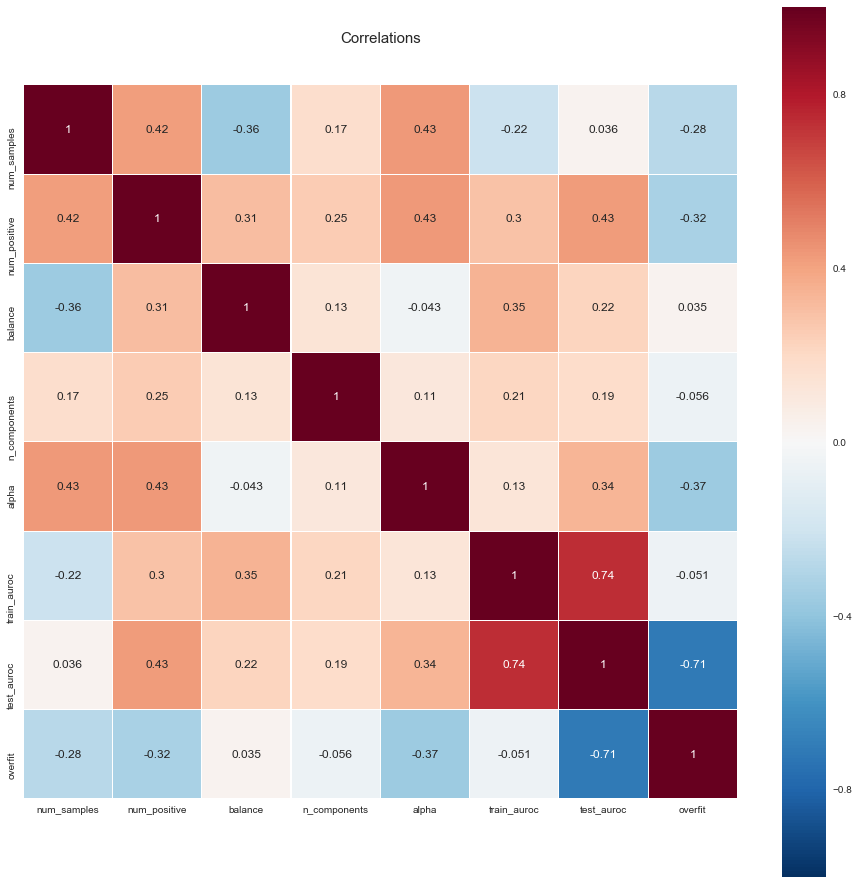

In [12]:
# Show how some of these metrics/parameters might be related
metrics_df_for_correlations = metrics_df_current_setup[['num_samples', 'num_positive', 'balance', 'n_components', 'alpha', 'train_auroc', 'test_auroc', 'overfit']]
plt.figure(figsize=(16,16))
plt.title('Correlations', y=1.05, size=15)
sns.heatmap(metrics_df_for_correlations.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, annot=True)
sns.plt.show()

### 3.c. Evaluate how changing some of the parameters effects performance

 - When a larger range of alpha and an L1_ratio of 0 were used for the queries with all diseases there was a large performance gain (~6%-8%)... will there be a similar performance gain with these queries?

In [13]:
%%time
# alpha and L1_ratio.
metrics_df = evaluate_classifier(X = X,
                                 y = y,
                                 list_of_queries = query_list,
                                 set_k_range = [10, 20],
                                 k_function = None,
                                 alpha_range = [10** x for x in range(-10, 10)],
                                 l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = True)

,num_samples,num_positive,balance,n_components,n_comp_status,alpha,alpha_status,train_auroc,test_auroc,overfit
58944691,4691,20,0.00426348,20,max,100,OK,0.786302,0.791176,-0.00487428
74861460,1460,20,0.0136986,20,max,100,OK,0.887695,0.671007,0.216688
251283,1283,20,0.0155885,20,max,0.01,OK,0.802908,0.513834,0.289074
51592405,2405,21,0.00873181,20,max,100,OK,0.817391,0.783019,0.0343722
4763502,502,21,0.0418327,10,min,10,OK,0.744026,0.363402,0.380624
56043310,3310,21,0.00634441,10,min,10,OK,0.838196,0.737842,0.100354
20641064,1064,21,0.0197368,20,max,1000,OK,0.720906,0.351675,0.369231
1956951,951,21,0.022082,20,max,100,OK,0.891774,0.836898,0.0548758
74903360,3360,21,0.00625,10,min,0.1,OK,0.590746,0.688623,-0.0978768
59791559,1559,21,0.0134702,20,max,1,OK,0.807987,0.863636,-0.0556498


,num_samples,num_positive,balance,n_components,alpha,train_auroc,test_auroc,overfit
mean,3041.51,124.623,0.0639019,18.3962,133307,0.80989,0.753168,0.0567219
median,2627,81,0.0318417,20,100,0.814416,0.762338,0.0295182


Mean testing Auroc improved by 3.06%
Median testing Auroc improved by 3.60%
Mean overfitting reduced by 1.1%
Median overfitting reduced by 1.6%
Wall time: 45min 40s


## 4.d. Use a function to select k (number of PCA components)
- You can't us n_components (which the select_K is realy just a proxy for in this notebook) larger than the smallest total query size * the test train split ratio * 1-(1/cv) (for example if there is a query that has 100 total samples and you do a 80%/20% split than the training set only has 80 samples in it and if you do 3 fold CV each training fold will only have 80*0.66 (54) samples, so you couldn't do PCA with anymore than 54 components).
 - There is a risk of overfitting if you use too many components for more unballanced queries
 - It requires less components to capture a reasonable amount of variance for queries with less samples
 - We haven't seen much of a clear coorelation with the two hueristics above; understanding them quantitatively has been difficult

In [14]:
def k_func(num_samples, num_positives):
    ''' Decide the number of PCA components based on a heuristic of total samples and class balance.
    '''
    # If there are more positives than negatives, set num_positives equal to the number of negatives
    num_positives = min(num_positives, num_samples - num_positives)
    # Rule of thumb based on number of positives
    k = 5 * math.sqrt(num_positives)
    # Adjust slightly for total number of samples
    k = k * ((num_samples / 7000)**(1./6.))
    k = [int(k)]
    return(k)

In [15]:
def k_func_proposed(num_samples, num_positives):
    ''' Simpler function proposed for use.
    '''
    # If there are more positives than negatives, set num_positives equal to the number of negatives
    num_positives = min(num_positives, num_samples - num_positives)
    # Rule of thumb based on number of positives
    if num_positives > 500:
        k = 100
    elif num_positives > 250:
        k = 50
    else:
        k = 30
    k = [int(k)]
    return(k)

What do the k_funcs look like?

In [16]:
def plot_k_func(k_func):
    X_plot = [] # number of samples
    Y_plot = [] # number of positives
    Z_plot = [] # k (number of components in PCA)
    for query in query_list:
        X_plot.append(query[2]['total'])
        Y_plot.append(query[2]['positive'])
        Z_plot.append(k_func(query[2]['total'], query[2]['positive']))


    plt.scatter(X_plot, Z_plot)
    plt.title('Number of Components vs. Query Size')
    plt.ylabel('K')
    plt.xlabel('Total Number of Samples')
    plt.show()

    plt.scatter(Y_plot, Z_plot)
    plt.title('Number of Components vs. Number of Positives')
    plt.ylabel('K')
    plt.xlabel('Number of Positives')
    plt.show()

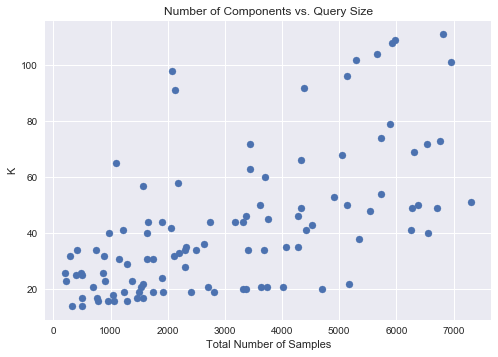

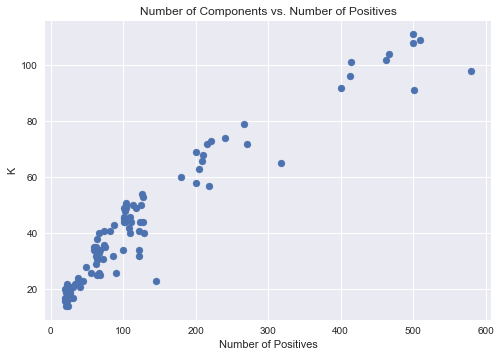

In [17]:
plot_k_func(k_func)

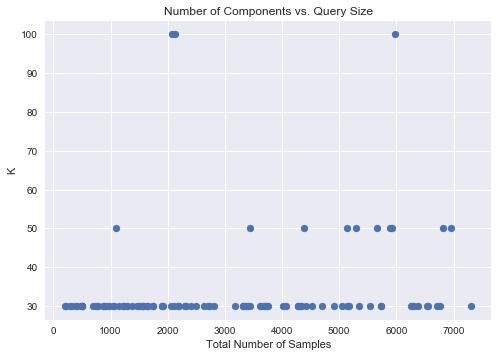

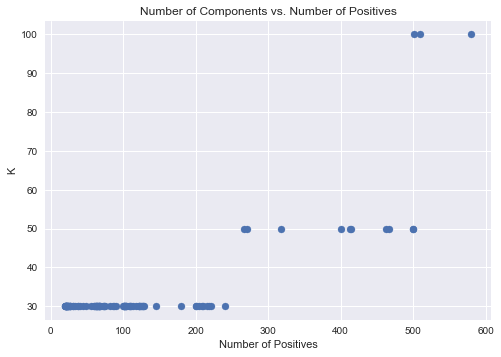

In [18]:
plot_k_func(k_func_proposed)

In [19]:
%%time
# k function.
metrics_df = evaluate_classifier(X = X,
                                 y = y,
                                 list_of_queries = query_list,
                                 set_k_range = None,
                                 k_function = k_func,
                                 alpha_range = [10** x for x in range(-3, 1)],
                                 l1_ratio = [0.15])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_samples,num_positive,balance,n_components,alpha,train_auroc,test_auroc,overfit
mean,3041.51,124.623,0.0639019,42.2736,0.537434,0.78007,0.7157,0.06437
median,2627,81,0.0318417,35,1,0.76961,0.718447,0.052919


Mean testing Auroc improved by -0.69%
Median testing Auroc improved by -0.79%
Mean overfitting reduced by 0.3%
Median overfitting reduced by -0.7%
Wall time: 52min 43s


In [20]:
%%time
# k function and alpha and l1_ratio.
metrics_df = evaluate_classifier(X = X,
                                 y = y,
                                 list_of_queries = query_list,
                                 set_k_range = None,
                                 k_function = k_func,
                                 alpha_range = [10** x for x in range(-10, 10)],
                                 l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = False)

,num_samples,num_positive,balance,n_components,alpha,train_auroc,test_auroc,overfit
mean,3041.51,124.623,0.0639019,42.2736,119157,0.836994,0.775042,0.0619518
median,2627,81,0.0318417,35,100,0.834954,0.788417,0.0355583


Mean testing Auroc improved by 5.25%
Median testing Auroc improved by 6.21%
Mean overfitting reduced by 0.5%
Median overfitting reduced by 1.0%
Wall time: 35min 38s


In [21]:
%%time
# proposed simpler k function and alpha and l1_ratio.
metrics_df = evaluate_classifier(X = X,
                                 y = y,
                                 list_of_queries = query_list,
                                 set_k_range = None,
                                 k_function = k_func_proposed,
                                 alpha_range = [10** x for x in range(-10, 10)],
                                 l1_ratio = [0])
display_stats(metrics_df, metrics_df_current_setup, verbose = True)

,num_samples,num_positive,balance,n_components,n_comp_status,alpha,alpha_status,train_auroc,test_auroc,overfit
58944691,4691,20,0.00426348,30,min,1e-05,OK,0.78652,0.822193,-0.0356728
74861460,1460,20,0.0136986,30,min,0.01,OK,0.859158,0.753472,0.105686
251283,1283,20,0.0155885,30,min,1000,OK,0.859158,0.477273,0.381886
51592405,2405,21,0.00873181,30,min,1000,OK,0.780622,0.772013,0.0086099
4763502,502,21,0.0418327,30,min,100000,OK,0.683211,0.32732,0.355891
56043310,3310,21,0.00634441,30,min,1000,OK,0.85255,0.889058,-0.0365078
20641064,1064,21,0.0197368,30,min,1000,OK,0.74277,0.348086,0.394684
1956951,951,21,0.022082,30,min,100,OK,0.907608,0.828877,0.0787313
74903360,3360,21,0.00625,30,min,10000000,OK,0.724492,0.796407,-0.0719154
59791559,1559,21,0.0134702,30,min,100000,OK,0.86791,0.895292,-0.0273821


,num_samples,num_positive,balance,n_components,alpha,train_auroc,test_auroc,overfit
mean,3041.51,124.623,0.0639019,33.8679,1.26733e+06,0.831054,0.776023,0.0550313
median,2627,81,0.0318417,30,100,0.830408,0.785022,0.0243272


Mean testing Auroc improved by 5.35%
Median testing Auroc improved by 5.87%
Mean overfitting reduced by 1.2%
Median overfitting reduced by 2.1%
Wall time: 33min 54s


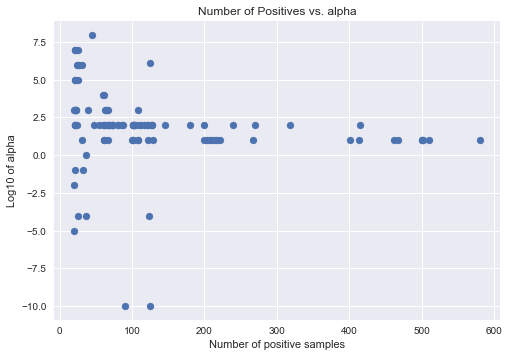

In [22]:
num_pos_plot = metrics_df['num_positive'].tolist()
alpha_plot = metrics_df['alpha'].tolist()
alpha_log10_plot = [math.log(a,10) for a in alpha_plot]
plt.scatter(num_pos_plot, alpha_log10_plot)
plt.title('Number of Positives vs. alpha')
plt.ylabel('Log10 of alpha')
plt.xlabel('Number of positive samples')
plt.show()
